<a href="https://colab.research.google.com/github/dribnet/clipit/blob/master/demos/Start_Here.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIPIT demo

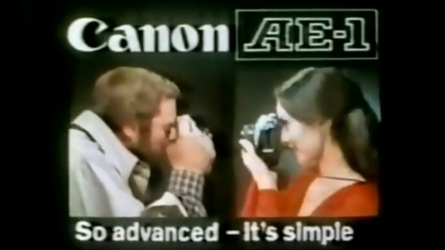

In [1]:
#@title Setup

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left. You should only need to run this part once.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

%%capture
!git clone https://github.com/openai/CLIP
# !pip install taming-transformers
!git clone https://github.com/CompVis/taming-transformers.git
!rm -Rf clipit
!git clone https://github.com/dribnet/clipit
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install imageio-ffmpeg   
!pip install einops
!pip install torch-optimizer
!pip install easydict
!pip install braceexpand
!pip install git+https://github.com/pvigier/perlin-numpy
!mkdir steps
!wget https://user-images.githubusercontent.com/945979/126260797-adc60317-9518-40de-8700-b1f93e81e0ec.png -O this_is_fine.png
!wget https://user-images.githubusercontent.com/945979/126415385-d70ff2b0-f021-4238-9621-6180d33b242c.jpg -O perfume.jpg
!curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.yaml' #ImageNet 16384
!curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.ckpt' #ImageNet 16384

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['forest of giant flowers as big as trees in the style of Ivan Bilibin']
Using seed: 18444069619921529454


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/kornia/utils/helpers.py:96: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  out1, out2 = torch.solve(input.to(dtype), A.to(dtype))


i: 0, loss: 1.8885, losses: 0.94485, 0.943652


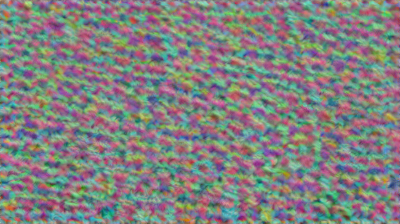

i: 50, loss: 1.46539, losses: 0.724581, 0.740811


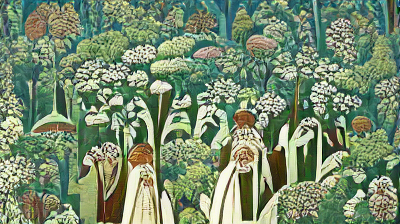

i: 100, loss: 1.44534, losses: 0.72139, 0.723954


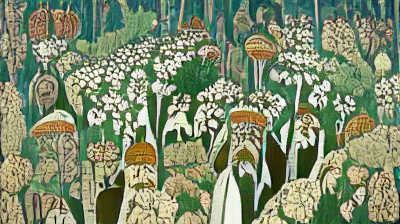

i: 150, loss: 1.34477, losses: 0.668665, 0.676105


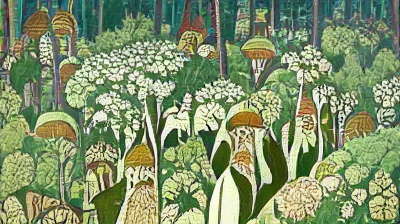

i: 200, loss: 1.40274, losses: 0.700184, 0.702557


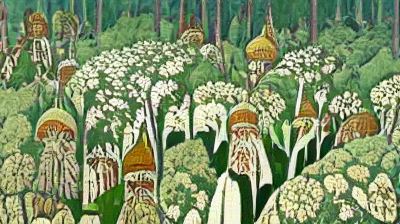

i: 250, loss: 1.41343, losses: 0.701752, 0.711677


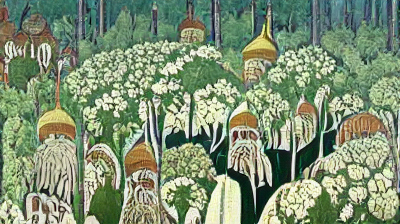

i: 300, loss: 1.29249, losses: 0.650327, 0.642159


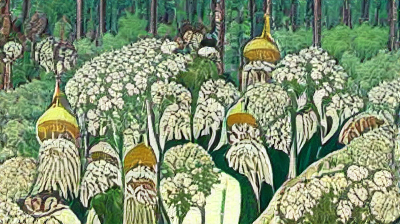

i: 350, loss: 1.38956, losses: 0.696492, 0.693064


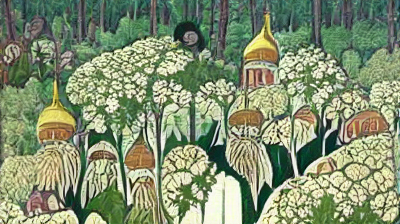

In [2]:
#@title Settings for your run

#@markdown This text prompt is what the computer will try to draw.

#@title Parameters
prompts = "forest of giant flowers as big as trees in the style of Ivan Bilibin" #@param {type:"string"}

#@markdown you can trade off speed for quality

quality = "normal" #@param ["draft", "normal", "better", "best"]

#@markdown some people actually like square?  ¯\\_(ツ)_/¯

aspect = "widescreen" #@param ["widescreen", "square"]

#@markdown When you have the settings you want, press the play button on the left.
#@markdown The system will start drawing and show you results as it goes along.

#@markdown _(I can get "better" running on the colabs, but not "best".
#@markdown Sometimes it is necessary to "Restart Runtime" to clear memory.)_

# Simple setup
from clipit import generate
import easydict

args = easydict.EasyDict({
    "prompts": prompts,
    "quality": quality,
    "aspect": aspect,
    "vqgan_config":'vqgan_imagenet_f16_16384.yaml',
    "vqgan_checkpoint": 'vqgan_imagenet_f16_16384.ckpt'
})

vq_parser = generate.setup_parser()
settings = generate.process_args(vq_parser, namespace=args)
generate.do_init(settings)

from IPython import display
generate.do_run(settings)